# 1.) Import an asset price from Yahoo Finance

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("AAPL", start="1990-01-01", end="2022-02-21")



# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]



[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day Build an RNN Architecture accordingly

In [ ]:
x_train = []
y_train = []


#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 5
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train.append(train_data[i, 0]) 
for i in range(len(y_train)):
    if y_train[i] > 0:
        y_train[i] = 1
    else:
        y_train[i] = 0


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
###################################
####Build Your RNN Architecture####
###################################

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=10, epochs=3)

Epoch 1/3
648/648 [==============================] - 14s 14ms/step - loss: 0.6934 - accuracy: 0.4833
Epoch 2/3
648/648 [==============================] - 6s 10ms/step - loss: 0.6933 - accuracy: 0.4972
Epoch 3/3
648/648 [==============================] - 7s 11ms/step - loss: 0.6932 - accuracy: 0.4994


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [ ]:
test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = []
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])
    y_test.append(test_data[i, 0])

for i in range(len(y_test)):
    if y_test[i] > 0:
        y_test[i] = 1
    else:
        y_test[i] = 0


x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))



In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Calculate predictions for the training and testing sets
train_preds = model.predict(x_train)
test_preds = model.predict(x_test)
train_zeros = np.zeros(len(y_train))
test_zeros = np.zeros(len(y_test))

train_acc = accuracy_score(y_train, np.round(train_preds))
train_rw_acc = accuracy_score(y_train, train_zeros)

test_acc = accuracy_score(y_test, np.round(test_preds))
test_rw_acc = accuracy_score(y_test, test_zeros)


51/51 [==============================] - 0s 4ms/step


0.5044808405438813 0.5024721878862793 0.47098765432098766 0.4679012345679012


Text(0.5, 1.0, 'Accuracy Scores')

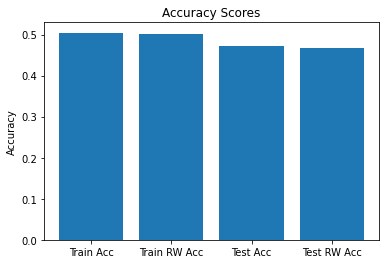

In [ ]:
labels = ['Train Acc', 'Train RW Acc', 'Test Acc', 'Test RW Acc']
values = [train_acc, train_rw_acc, test_acc, test_rw_acc]
print(train_acc, train_rw_acc, test_acc, test_rw_acc)
plt.bar(labels, values)
plt.ylabel('Accuracy')
plt.title('Accuracy Scores')


# 4.) Write an observation/conclusion about the graphs from Q4 and Q3

As we can see from the plot above, the model only performs a little bit better than the random walk model both in the in-sample and out of sample data, which indicates that our model may not be so good. 

# 5.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

def create_model(input_size):

  
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, batch_size=10, epochs=3)
    return model

# Wrap the Keras model in a scikit-learn compatible estimator
model = KerasRegressor(build_fn=create_model, verbose=0)


param_grid = {'epochs': [3],'input_size':[5,10,20]}

# Perform the grid search over the hyperparameters

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# Print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-15-6a09a73bf0ce>:17: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Epoch 1/3
648/648 [==============================] - 12s 11ms/step - loss: 0.6933 - accuracy: 0.5022
Epoch 2/3
648/648 [==============================] - 6s 10ms/step - loss: 0.6932 - accuracy: 0.5025
Epoch 3/3
648/648 [==============================] - 7s 11ms/step - loss: 0.6932 - accuracy: 0.5062
Best: -0.694597 using {'epochs': 3, 'input_size': 10}
